## setup

In [1]:
import torch
import intel_extension_for_pytorch as ipex

C:\Users\intel\miniforge3\envs\openvino\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\intel\miniforge3\envs\openvino\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\intel\miniforge3\envs\openvino\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import  AutoTokenizer,AutoModelForCausalLM
from optimum.intel import OVModelForCausalLM


model_name = 'gpt2'#'Den4ikAI/DLM_CHITCHAT_500M'#'model-attribution-challenge/bloom-350m' #'crumb/opentinystories-30m-base' #'PAIXAI/Astrid-1B-CPU'#'helenai/Salesforce-codegen2-1B-ov'#"OpenVINO/togethercomputer-RedPajama-INCITE-7B-Instruct-int8-compressed"
#model = OVModelForCausalLM.from_pretrained(model_name,export=True)#,compile=False)#,trust_remote_code=True)
#model.compile()
model=AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model

2024-09-03 05:30:12,234 - datasets - INFO - PyTorch version 2.1.0.post3+cxx11.abi available.


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# code

## tokenizing and padding

### tokenizing

tokenizing is when we take in an input string and turn it into a sequnce of integers representing the string.

gpt2 uses BPE for its tokenizer, which works by taking frequntly ocuring sequnces and give them 1 token.

In [4]:
print(tokenizer.encode('hi there'))
print(tokenizer.encode('uqp'))
print(tokenizer.encode(''))

[5303, 612]
[84, 80, 79]
[]


### padding

there r generally 2 ways of dealing with padding:
1. add a special pad token
2. use an existing token and let the mask handle it

we will use the second because dealing with an extra token is tricky

In [5]:
tokenizer.pad_token_id=tokenizer.eos_token_id

In [6]:
inputs=tokenizer(['hi',"hi I am longer"], return_tensors='pt',padding=True)
inputs

{'input_ids': tensor([[ 5303, 50256, 50256, 50256],
        [ 5303,   314,   716,  2392]]), 'attention_mask': tensor([[1, 0, 0, 0],
        [1, 1, 1, 1]])}

In [7]:
tokenizer.__dict__.keys()

dict_keys(['_tokenizer', '_decode_use_source_tokenizer', 'init_inputs', 'init_kwargs', 'name_or_path', '_processor_class', 'model_max_length', 'padding_side', 'truncation_side', 'model_input_names', 'clean_up_tokenization_spaces', 'split_special_tokens', 'deprecation_warnings', '_in_target_context_manager', 'chat_template', '_bos_token', '_eos_token', '_unk_token', '_sep_token', '_pad_token', '_cls_token', '_mask_token', '_pad_token_type_id', '_additional_special_tokens', 'verbose', 'add_bos_token', 'add_prefix_space'])

In [8]:
tokenizer._tokenizer.__dict__.keys()

dict_keys([])

In [9]:
output=model(**inputs)
output.logits.shape

torch.Size([2, 4, 50257])

In [11]:
x=inputs['input_ids']
print(x.shape,x.dtype)
model.transformer.wte(x).shape

torch.Size([2, 4]) torch.int64


torch.Size([2, 4, 768])

# gpt2 deep dive:

gpt2 and above are a take on the transformer architecture from "attention is all you need".

they simplfy and change the original architecture. (note that alot of online reasources get the diagram wrong)

.

this can be abit overwhelming at first and its okay if you dont get a full grasp on it right away.

especially with how there are small variation in implementation

## visualization

### attention

attention is the core idea behind a transformer.

it tells the model which token is the most important to look at

In [16]:
inputs=tokenizer(['victor was a rider and he went to'],return_tensors='pt')
output=model(**inputs,output_attentions=True)
[x.shape for x in output.attentions]

[torch.Size([1, 12, 9, 9]),
 torch.Size([1, 12, 9, 9]),
 torch.Size([1, 12, 9, 9]),
 torch.Size([1, 12, 9, 9]),
 torch.Size([1, 12, 9, 9]),
 torch.Size([1, 12, 9, 9]),
 torch.Size([1, 12, 9, 9]),
 torch.Size([1, 12, 9, 9]),
 torch.Size([1, 12, 9, 9]),
 torch.Size([1, 12, 9, 9]),
 torch.Size([1, 12, 9, 9]),
 torch.Size([1, 12, 9, 9])]

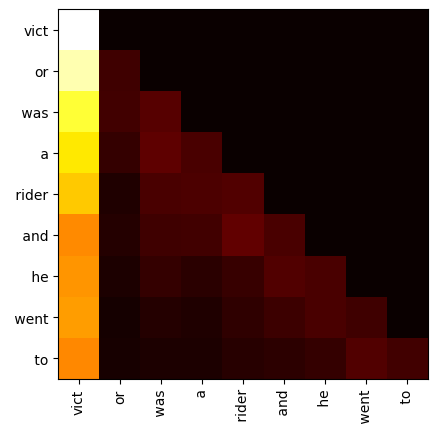

In [17]:
heatmap=torch.stack(output.attentions).mean(dim=(0,1,2)).detach().numpy()
plt.imshow(heatmap,cmap='hot')

tokens = [tokenizer.decode([token_id]) for token_id in inputs['input_ids'][0]]


# Label the axes with the decoded tokens
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens)
plt.show()

In [18]:
heatmap.sum(1)

array([1.        , 1.        , 0.99999994, 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        ], dtype=float32)

In [21]:
def show_atten(prompt,depth=12,letters=True):
  inputs=tokenizer([prompt],return_tensors='pt')
  output=model(**inputs,output_attentions=True)

  heatmap=torch.stack(output.attentions[:depth]).mean(dim=(0,1,2)).detach().numpy()
  plt.imshow(heatmap,cmap='hot')

  if(not letters):
    return
  tokens = [tokenizer.decode([token_id]) for token_id in inputs['input_ids'][0]]

  # Label the axes with the decoded tokens
  plt.xticks(range(len(tokens)), tokens, rotation=90)
  plt.yticks(range(len(tokens)), tokens)


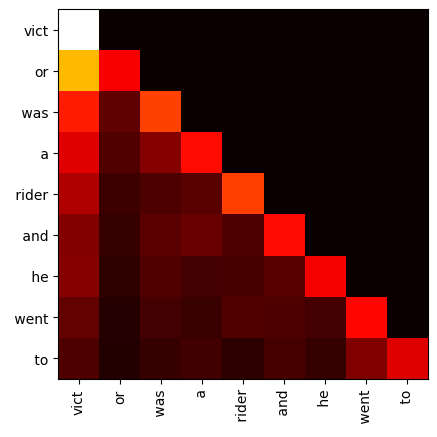

In [22]:
show_atten('victor was a rider and he went to',1)

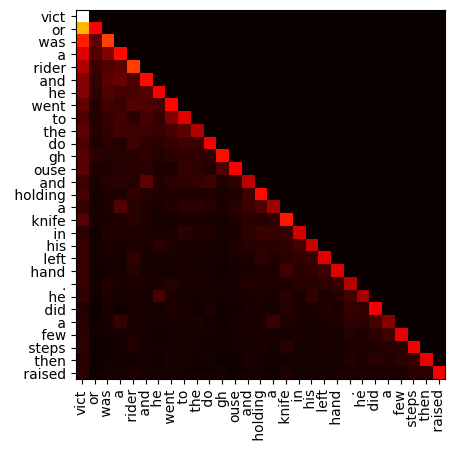

In [23]:
show_atten('victor was a rider and he went to the doghouse and holding a knife in his left hand. he did a few steps then raised',1)

In [24]:
wikipedia_philosophy='''Philosophy (love of wisdom in ancient Greek) is a systematic study of general and fundamental questions concerning topics like existence, reason, knowledge, value, mind, and language. It is a rational and critical inquiry that reflects on its own methods and assumptions.

Historically, many of the individual sciences, like physics and psychology, formed part of philosophy. But they are considered separate academic disciplines in the modern sense of the term. The main traditions in the history of philosophy include Western, Arabic-Persian, Indian, and Chinese philosophy. Western philosophy originated in Ancient Greece and covers a wide area of philosophical subfields. A central topic in Arabic-Persian philosophy is the relation between reason and revelation. Indian philosophy combines the spiritual problem of how to reach enlightenment with the exploration of the nature of reality and the ways of arriving at knowledge. Chinese philosophy focuses on practical issues in relation to right social conduct, government, and self-cultivation.

Major branches of philosophy are epistemology, ethics, logic, and metaphysics. Epistemology studies what knowledge is and how to acquire it. Ethics investigates moral principles and what constitutes right conduct. Logic is the study of correct reasoning and explores how good arguments can be distinguished from bad ones. Metaphysics examines the most general features of reality, existence, objects, and properties. Other notable subfields are aesthetics, philosophy of language, philosophy of mind, philosophy of religion, philosophy of science, philosophy of history, and political philosophy.

Philosophers use a great variety of methods to arrive at philosophical knowledge. They include conceptual analysis, reliance on common sense and intuitions, use of thought experiments, analysis of ordinary language, description of experience, and critical questioning. Philosophy is related to many other fields, like the sciences, mathematics, business, law, and journalism. It provides an interdisciplinary perspective and studies their scope and fundamental concepts. It also investigates their methods and ethical implications'''


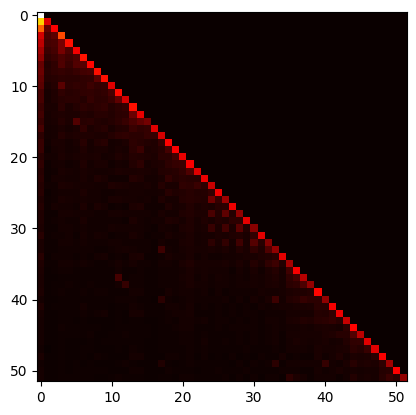

In [25]:
show_atten(wikipedia_philosophy.split('\n\n')[0],1,False)

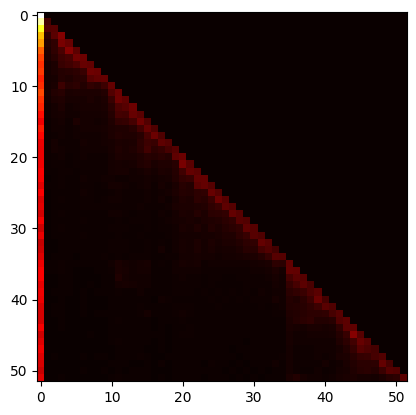

In [26]:
show_atten(wikipedia_philosophy.split('\n\n')[0],7,False)

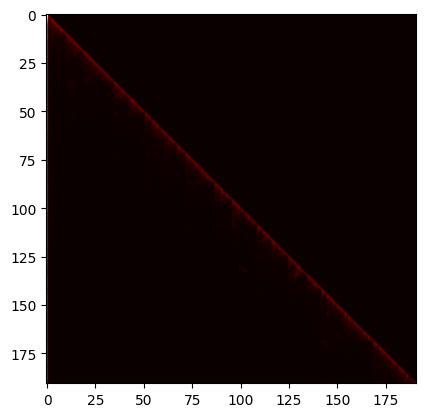

In [27]:
show_atten('\n\n'.join(wikipedia_philosophy.split('\n\n')[:2]),7,False)

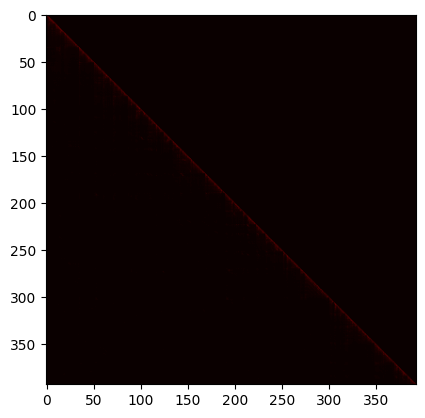

In [28]:
show_atten(wikipedia_philosophy,12,False)

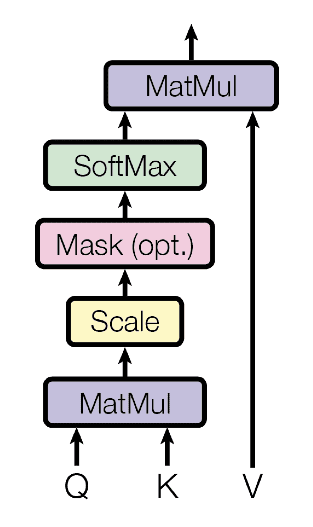

### positional encoding

the attention layer has now way of knowing the order of words in the sentance.

and since the mlp layer is just a linear layer applied to each token.

a tramsformer has no way of knowing where tokens are located


.

to fix this issue we use positional encoding

its a vector that is added for each position in the sequnce.

there are 2 versions:

1. give each position a trainble vector

2. use premade constant vectors (usually made with cosine and sin to alow for extention to any sequnce length)

gpt2 uses the first one.

In [31]:
positional_embeding=model.transformer.wpe
positional_embeding

Embedding(1024, 768)

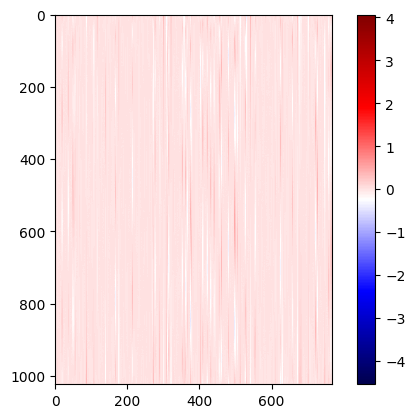

In [32]:
plt.imshow(positional_embeding(torch.arange(1024)).detach(),cmap='seismic')
plt.colorbar()

### transformer

this is a diagram of gpt2's architecture

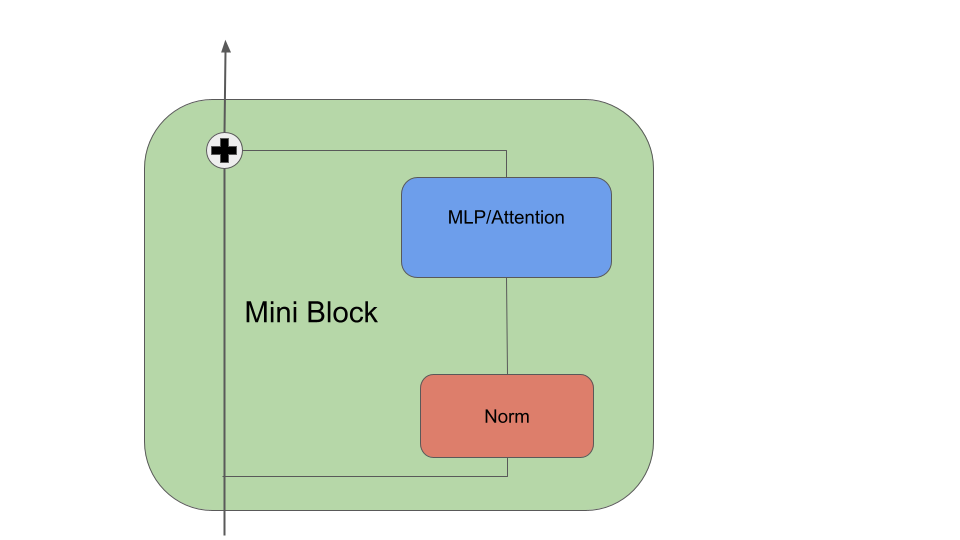

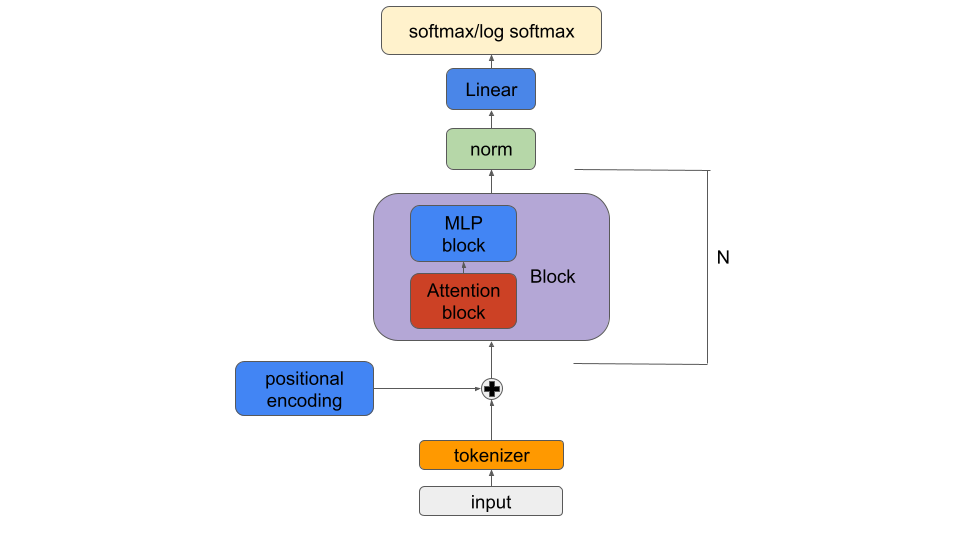

notice that norm is always called before atten and mlp.

this desgin choice is the genuise behind gpt2 it alows the gradients to flow mostly linearly backwards which alows for faster learning

there is another small technical diffrence and thats the last softmax.
in huggingface this layer is not part of the model to alow us to work more acurately with the log probabileties if we want.

## paper

here is the actual code from the paper on how a block is implemented

https://github.com/openai/gpt-2/blob/master/src/model.py

In [ ]:
def multihead_attn(q, k, v):
        # q, k, v have shape [batch, heads, sequence, features]
        w = tf.matmul(q, k, transpose_b=True)
        w = w * tf.rsqrt(tf.cast(v.shape[-1].value, w.dtype))

        w = mask_attn_weights(w)
        w = softmax(w)
        a = tf.matmul(w, v)
        return a

In [ ]:
def mlp(x, scope, n_state, *, hparams):
    with tf.variable_scope(scope):
        nx = x.shape[-1].value
        h = gelu(conv1d(x, 'c_fc', n_state))
        h2 = conv1d(h, 'c_proj', nx)
        return h2


In [ ]:

def block(x, scope, *, past, hparams):
    with tf.variable_scope(scope):
        nx = x.shape[-1].value
        a, present = attn(norm(x, 'ln_1'), 'attn', nx, past=past, hparams=hparams)
        x = x + a
        m = mlp(norm(x, 'ln_2'), 'mlp', nx*4, hparams=hparams)
        x = x + m
        return x, present